# Wine Reviews

In this problem, we will predit the price of an AirBnB listing as a function of its attributes. We get our data from this source: https://www.kaggle.com/c/airbnblala/data#

Our first step will be to import all of the modules we need, and then load the data.

In [1]:
using Random
Random.seed!(13)

using CSV
using Plots
using DataFrames
using Statistics
using StatsPlots

In [2]:
df = CSV.read("wines.csv")

df = df[1:20000,:]
# let's list all available categories, as well as their datatype using the "eltype" function.
feature_names = names(df)
"""
for i in 1:96
    println(string(i), "\t", string(feature_names[i]), "\t\t\t", string(eltype(df[!, i])))
end
"""

"for i in 1:96\n    println(string(i), \"\t\", string(feature_names[i]), \"\t\t\t\", string(eltype(df[!, i])))\nend\n"

## a) Train / Test Split


The last three features are price; let's say that column 61 is the label to predict, and let's hide 62 and 63.

We now will generate a "data" collection, a "target" collection (column 61), and create a train/test split so that we can empirically test for overfitting.

To make the 80 / 20 train test split, we are going to shuffle the data, and then select the first $80\%$ as the train data, with $20\%$ held out for validation.

Use the code below to create a train / test split.

In [3]:
df = df[.!(ismissing.(df[!, :price])), :]; # let's only consider the examples for which the price is known

train_proportion = 0.8
n = size(df, 1)
println("Size of dataset: ", string(n))

# Put the first ntrain observations in the DataFrame df into the training set, and the rest into the test set
ntrain = convert(Int, round(train_proportion*n))

target = df[:, :price];
data = df[:, filter(col -> (col != :price), feature_names)];

Size of dataset: 20000


In [4]:
df = df[.!(ismissing.(df[!, :points])), :];

In [5]:
cat_labels = [
  :country,
  :province,
    :variety,
    :winery
]
# :designation,
# :region_1,
#  :region_2,
# :winery

4-element Array{Symbol,1}:
 :country 
 :province
 :variety 
 :winery  

In [6]:
size(df)

(20000, 13)

In [7]:
# the following variable records the features of examples in the training set
train_x = data[1 : ntrain, :];
# the following variable records the features of examples in the test set
test_x = data[ntrain+1 : n, :];
# the following variable records the labels of examples in the training set
train_y = target[1 : ntrain, :];
# the following variable records the labels of examples in the test set
test_y = target[ntrain+1 : n, :];

## Real data: Points

In [ ]:
# the following variable should have as many columns as real variables, and as many rows as examples in the training set      
train_vals_real = train_x[:,:points];
# the following variable should have as many columns as real variables, and as many rows as examples in the test set      
test_vals_real = test_x[:, :points];

# typeof: DataFrame

In [ ]:
train_vals_real = convert(Matrix, train_vals_real);
test_vals_real = convert(Matrix, test_vals_real);

In [ ]:
Xtrain = hcat(train_vals_from_string, train_vals_real);
Xtest = hcat(test_vals_from_string, test_vals_real);

## MSE

In [8]:
"""This function just computes the mean squared error."""
function MSE(y, pred)
    n = size(y,1)
    return (sum((y - pred).^2))/n  
end

"""This function plots the main diagonal; 
for a "predicted vs true" plot with perfect predictions,
all data lies on this line"""
function plotDiagonal(xmin, xmax)
    xsamples = [xmin, xmax]
    plot!(xsamples, xsamples, color=:black)
end

"""This helper funciton plots x vs, y and labels the axes."""
function plotdata(x,y,xname, yname; margin=.05, plotDiag=true, zeromin=false)
    scatter(x,y, label="data")
    xlabel!(xname)
    ylabel!(yname)
    range_y = maximum(y) - minimum(y)
    range_x = maximum(x) - minimum(x)
    if plotDiag
        plotDiagonal(minimum(x)-margin*range_x, maximum(x)+margin*range_x)
    end
    if zeromin
        ylims!((0.0,maximum(y)+margin*range_y))
        xlims!((0.0,maximum(x)+margin*range_x))
    else
        ylims!((minimum(y)-margin*range_y,maximum(y)+margin*range_y))
        xlims!((minimum(x)-margin*range_x,maximum(x)+margin*range_x))
    end
end

"""This function plots the predicted labels vs the actual labels
(We only plots the first 1000 points to avoid slow plots.)"""
function plot_pred_true(test_pred, test_y, max_points = 1000)
    plotdata(test_pred[1:max_points], test_y[1:max_points], "Predicted (\$)", "True (\$)", zeromin=true)
end

plot_pred_true

In [ ]:
Xtrain = [ones(size(train_vals_real,1)) train_vals_real];
Xtest = [ones(size(test_vals_real,1)) test_vals_real];
size(Xtrain)

In [ ]:
# The weights of your linear equation (compute via least squares)
w = Xtrain \ train_y;

In [ ]:
train_pred = Xtrain * w;
test_pred = Xtest * w;

train_MSE = MSE(train_y, train_pred);
test_MSE = MSE(test_y, test_pred);

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

In [ ]:
#println("Train MSE\t", train_MSE)
#println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y)

## d) Categorical Data

In [9]:
#Sets of all categories in a particular column
cats_sets = [unique(train_x[:, label]) for label in cat_labels];

In [10]:
"Computes a onehot vector for every entry in column given a set of categories cats"
function onehot(column, cats=unique(column))
    result = zeros((size(column,1) , size(cats,1)))
    for j in 1:size(cats,1)
        for i in 1:size(column, 1)
            if column[i] == cats[j]
                result[i,j] = 1                    
            end
        end
    end
    result
end

onehot

In [11]:
train_cat_vals = hcat([onehot(train_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...);
test_cat_vals = hcat([onehot(test_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...);

In [12]:
train_vals = hcat(Xtrain, train_cat_vals);
test_vals = hcat(Xtest, test_cat_vals);

UndefVarError: UndefVarError: Xtrain not defined

In [13]:
size(train_cat_vals)

(16000, 7754)

In [14]:
w = train_cat_vals\train_y;

In [15]:
train_pred = train_cat_vals*w;
test_pred = test_cat_vals*w;

train_MSE = MSE(train_y, train_pred);
test_MSE = MSE(test_y, test_pred);
        
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

Train MSE	375.6011737053884
Test MSE 	1206.693849764439


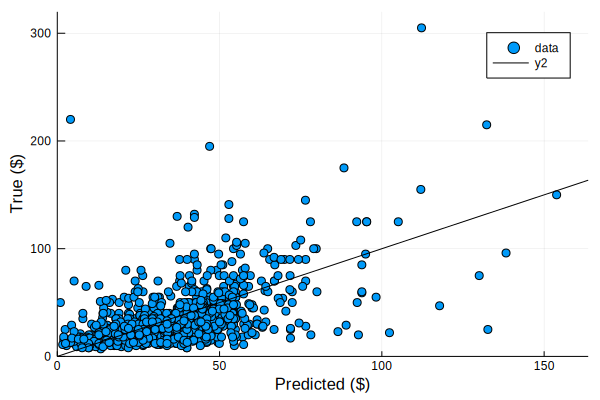

In [16]:
plot_pred_true(test_pred, test_y)

We're making significant improvements! We have reduced the MSE from before by $10 \%$ using this set of parameters.

## e) Set data

There is another type of data - stored in the host_verifications column - that we haven't used yet. This is set data, best encoded with a many-hot vector.

This particular column does not turn out to be particularly informative, but it is valuable to learn how to work with sets.

Notice is that the set data happens to be stored in a format that is very close to a valid declaration of a Julia string array:

In [ ]:
print(train_x[1, :host_verifications])

All we need to do is run "replace" to fix the single quotes into double quotes:

In [ ]:
replace(train_x[1, :host_verifications], "'" => "\"")

Why is that an improvement? Well, let's talk about how Julia handles input in general. Every input first appears as a string, like this:

In [ ]:
command = "2 + 2"

This command is then parsed into an intermediate representation known as an "Expr" type. This is useful for Julia so that it can break apart the epxression into underlying parts later, and evaluate intermediate results as they are needed (we won't go into much detail about interpreted languages here):

In [ ]:
typeof(command)

In [ ]:
ex = Meta.parse(command)
typeof(ex)

To go from expression to result, the "eval" command is used:

In [ ]:
eval(ex)

With all this in mind, write a simple function which takes one of the strings in the column :host_verifications, and outputs the corresponding String array:

In [ ]:
sample_input = "['email', 'facebook']"
desired_ouput = ["email", "facebook"]

In [ ]:
# prepro1(s) = Meta.parse(replace(sample_input, "'" => "\""))
prepro1(s) = eval(Meta.parse(replace(s, "'" => "\"")))

In [ ]:
# Check that prepro1 consumes sample_input to produce desired_output.
desired_ouput = prepro1(sample_input)

In [ ]:
# Also check it on the sample below:
a = prepro1(train_x[1, :host_verifications])
println(a)
println(typeof(a))

### Important: Be very careful using this technique in practice! 
Directly parsing and executing data that comes in String form opens a fantastic door to hackers, especially if you are gathering data in an online way for any institution that handles money. If you aren't careful, what I described is a fantastic way to get SQL-injected. In this case, however, we have full knowledge of the data and its source, and it simply makes more sense to use Julia's built-in parsing functions than write our own from scratch (not that this would be a true hurdle). Usually, before handling data in this way, we would need to do substantially more sanitization. It's good to see a little under-the-hood and understand the tools that you are using - similar functions are avaialable in Python and other interpreted languages - but it's also very important to know the vulnerabilities of your code.



We can now apply this function elementwise, to the entire column:

In [ ]:
verif_tr = prepro1.(train_x[:, :host_verifications]);
verif_te = prepro1.(test_x[:, :host_verifications]);

In [ ]:
typeof(verif_tr)

In [ ]:
typeof(verif_tr[1])

In [ ]:
verif_tr[1]

In [ ]:
eval.(verif_tr);

In [ ]:
eval(verif_tr[1])

By the way, if you are working on your project, there is a decent chance that sets were stored in a format similar to what we saw here. Using similar string compositions, you will likely be able to similarly parse the data into Julia container types (whether arrays or proper Julia sets)

Now, take this array of arrays, and turn it into a many-hot vector. You are welcome to use the nested loop structure below, or array comprehensions, or even the DataFrame object if you wish.

In [ ]:
# This is the collection of all types we need to worry about.
# Notice the use of "vcat," which is like "hcat" but vertical
vtypes = unique(vcat(verif_tr...))

In [ ]:
size(vtypes,1)

In [ ]:
verif_tr;
unique(verif_tr);

In [ ]:
"Computes a manyhot vector for every entry in an array of arrays given a set of categories cats"
function manyhot(column, cats=unique(col))
    nn = size(cats, 1)
    result = zeros((size(column,1), nn))
    for j in 1:size(column,1)
        set_of_descriptions = eval(column[j])
        for description in set_of_descriptions
            for i in 1:nn
                if description == cats[i]
                    result[j,i] = 1
                end              
            end
        end
    end
    result
end

"""why need 2 parameters? onehot only has one parameter"""
vtr_vals = manyhot(verif_tr, vtypes)
vte_vals = manyhot(verif_te, vtypes)

print(vtypes)
vtr_vals;

We will attach it to the full list of values used so far, but it won't change the MSE much, unfortunately:

In [ ]:
size(train_vals)

In [ ]:
train_vals = hcat(train_vals, vtr_vals);
test_vals = hcat(test_vals, vte_vals);

In [ ]:
size(train_vals)

In [ ]:
w = train_vals \ train_y;

In [ ]:
train_pred = train_vals*w;
test_pred = test_vals*w;

train_MSE = MSE(train_y, train_pred);
test_MSE = MSE(test_y, test_pred);
        
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

In [ ]:
plot_pred_true(test_pred, test_y)

## f) Location, location, location

If you remember, a common refrain in Real Estate is "location, location, location." We're treating Manhattan properties with the same formula as Staten Island!

The most naive way to include location data would be with the categories "latitude" and "longitude" - after all, these are continuous variables, so why not include them in the simplest manner possible?

Load the longitude and lattitude data in, then fit a model to predict the labels using *only* these variables.

In [ ]:
loc_labels = [
    :latitude,
    :longitude
]

# Extract these as real values, append a bias (all ones) feature,   
train_loc_vals = convert(Matrix, train_x[:, filter(col -> (col in loc_labels) ,loc_labels)]);
test_loc_vals = convert(Matrix, test_x[:, filter(col -> (col in loc_labels) ,loc_labels)]);

train_loc = [ones(size(train_loc_vals,1)) train_loc_vals];
test_loc = [ones(size(test_loc_vals,1)) test_loc_vals];

In [ ]:
size(train_loc)

In [ ]:
size(train_y)

In [ ]:
# fit a least squares model, and compute the MSE.
w = train_loc \ train_y 

train_pred = train_loc*w;
test_pred = test_loc*w;

train_MSE = MSE(train_y, train_pred);
test_MSE = MSE(test_y, test_pred);
        
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

In [ ]:
plot_pred_true(test_pred, test_y)

Clearly, this predictor is insufficient. Price is a nonlinear function of location; simply going north or south does not linearly affect the rental price.

There are several solutions. We could allow higher order polynomials in longitude and latitude:

In [ ]:
# create arrays of polynomial features in latitude and longitude up to order 2
train_lv2 = hcat(
    train_loc_vals[:, 1], train_loc_vals[:, 2],
    train_loc_vals[:, 1].^2, train_loc_vals[:, 1].*train_loc_vals[:, 2], train_loc_vals[:, 2].^2,
    ones(size(train_loc_vals, 1))
)
    
test_lv2 = hcat(
    test_loc_vals[:, 1], test_loc_vals[:, 2],
    test_loc_vals[:, 1].^2, test_loc_vals[:, 1].*test_loc_vals[:, 2], test_loc_vals[:, 2].^2,
    ones(size(test_loc_vals, 1))
)

# build a model using these polynomial features of latitude and longitude
w_loc = train_lv2 \ train_y

train_pred = train_lv2 * w_loc;
test_pred = test_lv2 * w_loc;

train_MSE = MSE(train_y, train_pred);
test_MSE = MSE(test_y, test_pred);
        
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

In [ ]:
plot_pred_true(test_pred, test_y)

The polynomial expansion is not particularly useful (or sensible) for location. Instead, let's consider a simpler feature transformation. 

Every location can be associated not only with its longitude and latitude, but also with a number of other categorical location parameters. Ones that appear in this dataset include:

  - street
  - neighbourhood
  - neighbourhood_cleansed
  - neighbourhood_group_cleansed
  - city
  - state
  - zipcode
  - market
  - smart_location
  - country_code
  - country
  
Let's see if zipcode predicts price well.

In the next cell, build a model that predicts price using a one-hot encoding of zipcode. Print the train and test MSE.

In [ ]:
zipcodes = unique(vcat(unique(train_x.zipcode),unique(test_x.zipcode)));

In [ ]:
size(zipcodes)

In [ ]:
train_zip = onehot(train_x.zipcode, cats = zipcodes);
test_zip = onehot(test_x.zipcode, cats = zipcodes);

In [ ]:
size(train_zip)

In [ ]:
size(test_zip)

In [ ]:
size(train_y)

In [ ]:
w_zip = train_zip\train_y;

In [ ]:
train_pred = train_zip*w_zip;
test_pred = test_zip*w_zip;

train_MSE = MSE(train_y, train_pred);
test_MSE = MSE(test_y, test_pred);
        
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

In [ ]:
plot_pred_true(test_pred, test_y)

Not bad for one (categorical) feature! Now fit a model on both the one-hot zip code together with the other features that we've already accumulated from the previous parts. Print the MSE scores and draw the plots for the full set:

In [ ]:
Xtrain = hcat(train_vals, train_zip);
Xtest = hcat(test_vals, test_zip);

In [ ]:
size(Xtrain)

In [ ]:
w = Xtrain \ train_y;

In [ ]:
train_pred = Xtrain * w;
test_pred = Xtest * w;

train_MSE = MSE(train_y, train_pred);
test_MSE = MSE(test_y, test_pred);
        
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

In [ ]:
plot_pred_true(test_pred, test_y)

This is by far the best result so far. It seems that location brought in some new information, giving us significantly more predictive power.

Can we do better by using text data?

## g) Text

The following columns consist of long-form textual descriptions:

  - name
  - summary
  - space
  - neighborhood_overview
  - notes
  - transit
  - access
  - interaction
  - house_rules

We will experiment with using features from a pretrained neural network to represent this data.
The neural network has learned an internal representation (say, at some hidden layer of the network) that it uses to make its predictions on a different task (such as sentiment prediction for sentences). 

We will use this internal representation directly for our task of AirBnB price prediction.
Using an internal representation from an unrelated model as a feature is a common technique known as transfer learning.

We will use pretrained features from the Universal Sentence Encoder (USE), which was designed explicitly for transfer learning to different tasks. 
[This paper](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/46808.pdf) documents how this neural network architecture was designed and trained: 
This network consumes text of arbitrary length, and produces a feature vector of length $512$. 

Your TAs have precomputed these features for all of the columns above into the table "airbnb-use-embeddings.csv",
available [as a zip file on the course website](https://people.orie.cornell.edu/mru8/orie4741/homework/airbnb-use-embeddings.csv.zip).
The id of each AirBnB listing is provided, along with features with names of the form "column_number:feature_number". That is, the 468th feature of the 5th text data column (also known as the "name" column) will be found at '5:468'.

You can use [this demo code](https://tfhub.dev/google/universal-sentence-encoder/2)) to explore the USE embedding further. If you would like to use this (or any other) embedding for your project, you are welcome to come to Office Hours and we will gladly help you with your project.

Returning to the AirBnB dataset, we can import the data into a new dataframe. Since our training data has been shuffled, we use a dataset join to assemble the data below.

In [ ]:
# df_tf = CSV.read("airbnb-use-embeddings.csv")
df_tf = CSV.read("All_embeddings2.csv")

In [ ]:
train_all = join(train_x, df_tf, on=:id, kind=:left);
test_all = join(test_x, df_tf, on=:id, kind=:left);

In [ ]:
print(size(train_x))
train_embed = convert(Matrix, train_all[:, 94:end]);
test_embed = convert(Matrix, test_all[:, 94:end]);

To find out how useful these parameters are (or aren't), fit a linear model of price as a function of embedding only (with offset!). Keep in mind that the backslash operator may require several minutes of computation for such a large problem.

In [ ]:
# + offset
train_embed_offset = [ones(size(train_embed,1)) train_embed];

In [ ]:
test_embed_offset = [ones(size(test_embed,1)) test_embed];

In [ ]:
w_embed = train_embed_offset \ train_y;

In [ ]:
# w_embed = train_embed \ train_y;

In [ ]:
train_pred = train_embed_offset * w_embed;
test_pred = test_embed_offset * w_embed;

train_MSE = MSE(train_y, train_pred);
test_MSE = MSE(test_y, test_pred);
        
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

In [ ]:
plot_pred_true(test_pred, test_y)

Two things are readily apparent: this embedding provides a lot of information, but we are massively overfitting. This is to be expected: after all we have $4689$ parameters to fit, but only $20000$ training points.

Now, is this embedding is capturing new information compared to the other columns? 
To test this, fit a least squares predictor using all of the features we have discussed in this notebook.
Compute MSE and plot the predicted vs expected score.

In [ ]:
Xtrain_all = hcat(Xtrain, train_embed);
Xtest_all = hcat(Xtest, test_embed);

In [ ]:
size(Xtrain_all)

In [ ]:
w_all = Xtrain_all \ train_y;

In [ ]:
train_pred = Xtrain_all * w_all;
test_pred = Xtest_all * w_all;

In [ ]:
train_MSE = MSE(train_y, train_pred);
test_MSE = MSE(test_y, test_pred);
        
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

In [ ]:
plot_pred_true(test_pred, test_y)

## Extra Credit

How can you explain these results? And is there any way you can fix them to improve the test error?